# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import optuna
import datetime
import random
import os

%load_ext tensorboard

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

In [3]:
def load_data():
    # load
    data_path = 'https://raw.githubusercontent.com/antbartash/max_temp/master/data/data_features_w_base.csv'
    data = pd.read_csv(data_path)
    data['DATE'] = data['DATE'].astype('datetime64[ns]')

    # split
    X_train = data.loc[data['DATE'].dt.year <= 2021].drop(columns=['TARGET', 'DATE']).copy()
    y_train = data.loc[data['DATE'].dt.year <= 2021, 'TARGET'].copy()
    X_valid = data.loc[data['DATE'].dt.year == 2022].drop(columns=['TARGET', 'DATE']).copy()
    y_valid = data.loc[data['DATE'].dt.year == 2022, 'TARGET'].copy()
    X_test = data.loc[data['DATE'].dt.year == 2023].drop(columns=['TARGET', 'DATE']).copy()
    y_test = data.loc[data['DATE'].dt.year == 2023, 'TARGET'].copy()

    # scale
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=scaler.feature_names_in_)
    X_valid = pd.DataFrame(scaler.transform(X_valid), columns=scaler.feature_names_in_)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.feature_names_in_)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [4]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_data()
print(f'Train: {X_train.shape}, {y_train.shape}')
print(f'Valid: {X_valid.shape}, {y_valid.shape}')
print(f'Test: {X_test.shape}, {y_test.shape}')

Train: (34938, 66), (34938,)
Valid: (2920, 66), (2920,)
Test: (2920, 66), (2920,)


# Model

In [5]:
def create_model(trial, input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    
    # layer 0
    n_units_0 = trial.suggest_int('nunints_layer_0', 32, 2048, step=32)
    actv_func_0 = trial.suggest_categorical('actv_func_layer_0', ['relu', 'leaky_relu', 'elu', 'sigmoid', 'tanh', 'gelu'])

    bias_reg_init_0 = trial.suggest_categorical('bias_reg_init_layer_0', ['l1', 'l2', 'l1l2', None])
    if bias_reg_init_0 == 'l1':
        bias_reg_0 = tf.keras.regularizers.l1(trial.suggest_float('bias_reg_layer_0', 0.0001, 0.5))
    elif bias_reg_init_0 == 'l2':
        bias_reg_0 = tf.keras.regularizers.l2(trial.suggest_float('bias_reg_layer_0', 0.0001, 0.5))
    elif bias_reg_init_0 == 'l1l2':
        bias_reg_0 = tf.keras.regularizers.L1L2(trial.suggest_float('bias_reg_layer_0_l1', 0.0001, 0.5),
                                                trial.suggest_float('bias_reg_layer_0_l2', 0.0001, 0.5))
    else:
        bias_reg_0 = None

    kernel_reg_init_0 = trial.suggest_categorical('kernel_reg_init_layer_0', ['l1', 'l2', 'l1l2', None])
    if kernel_reg_init_0 == 'l1':
        kernel_reg_0 = tf.keras.regularizers.l1(trial.suggest_float('kernel_reg_layer_0', 0.0001, 0.5))
    elif kernel_reg_init_0 == 'l2':
        kernel_reg_0 = tf.keras.regularizers.l2(trial.suggest_float('kernel_reg_layer_0', 0.0001, 0.5))
    elif kernel_reg_init_0 == 'l1l2':
        kernel_reg_0 = tf.keras.regularizers.L1L2(trial.suggest_float('kernel_reg_layer_0_l1', 0.0001, 0.5),
                                                  trial.suggest_float('kernel_reg_layer_0_l2', 0.0001, 0.5))
    else:
        kernel_reg_0 = None

    kernel_initializer_0 = trial.suggest_categorical(
        'kernel_initializer_layer_0', ['glorot_uniform', 'glorot_normal',
                                       'he_uniform', 'he_normal',
                                       'lecun_uniform', 'lecun_normal']
    )
    
    model.add(
        tf.keras.layers.Dense(
            units=n_units_0, activation=actv_func_0, 
            kernel_initializer=kernel_initializer_0,
            bias_regularizer=bias_reg_0,
            kernel_regularizer=kernel_reg_0
        )
    )

    
    # hidden layers
    num_layers = trial.suggest_int('num_layers', 0, 4)
    batch_norm = trial.suggest_categorical(f'batch_norm', [True, False])
    for layer_num in range(num_layers):
        layer_i = layer_num + 1
        n_units = trial.suggest_int(f'nunits_layer_{layer_i}', 32, 2048, step=32)
        actv_func = trial.suggest_categorical(f'actv_func_layer_{layer_i}', ['relu', 'leaky_relu', 'elu', 'sigmoid', 'tanh', 'gelu'])

        bias_reg_init = trial.suggest_categorical(f'bias_reg_init_layer_{layer_i}', ['l1', 'l2', 'l1l2', None])
        if bias_reg_init == 'l1':
            bias_reg = tf.keras.regularizers.l1(trial.suggest_float(f'bias_reg_layer_{layer_i}', 0.0001, 0.5))
        elif bias_reg_init == 'l2':
            bias_reg = tf.keras.regularizers.l2(trial.suggest_float(f'bias_reg_layer_{layer_i}', 0.0001, 0.5))
        elif bias_reg_init == 'l1l2':
            bias_reg = tf.keras.regularizers.L1L2(trial.suggest_float(f'bias_reg_layer_{layer_i}_l1', 0.0001, 0.5),
                                                  trial.suggest_float(f'bias_reg_layer_{layer_i}_l2', 0.0001, 0.5))
        else:
            bias_reg = None

        kernel_reg_init = trial.suggest_categorical(f'kernel_reg_init_layer_{layer_i}', ['l1', 'l2', 'l1l2', None])
        if kernel_reg_init == 'l1':
            kernel_reg = tf.keras.regularizers.l1(trial.suggest_float(f'kernel_reg_layer_{layer_i}', 0.0001, 0.5))
        elif kernel_reg_init == 'l2':
            kernel_reg = tf.keras.regularizers.l2(trial.suggest_float(f'kernel_reg_layer_{layer_i}', 0.0001, 0.5))
        elif kernel_reg_init == 'l1l2':
            kernel_reg = tf.keras.regularizers.L1L2(trial.suggest_float(f'kernel_reg_layer_{layer_i}_l1', 0.0001, 0.5),
                                                    trial.suggest_float(f'kernel_reg_layer_{layer_i}_l2', 0.0001, 0.5))
        else:
            kernel_reg = None

        kernel_initializer = trial.suggest_categorical(
            f'kernel_initializer_layer_{layer_i}', ['glorot_uniform', 'glorot_normal',
                                                    'he_uniform', 'he_normal',
                                                    'lecun_uniform', 'lecun_normal']
        )
        
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{layer_i}', 0.0, 0.999)
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(
            tf.keras.layers.Dense(
                n_units, actv_func, 
                kernel_initializer=kernel_initializer,
                bias_regularizer=bias_reg,
                kernel_regularizer=kernel_reg
            )
        )
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    dropout_rate = trial.suggest_float(f'dropout_rate_layer_output', 0.0, 0.999)
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    return model

# Optimizer

In [6]:
def create_optimizer(trial):
    opt_kwargs = {}
    opt_init = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'Nadam', 'Adamax'])
    if opt_init == 'SGD':
        opt_kwargs['learning_rate'] = trial.suggest_float('opt_lr', 1e-2, 1e-1, log=True)
        opt_kwargs['momentum'] = trial.suggest_float('opt_momentum', 1e-5, 0.1, log=True)
        opt_kwargs['nesterov'] = trial.suggest_categorical('opt_nesterov', [True, False])
    if opt_init == 'Adam':
        opt_kwargs['learning_rate'] = trial.suggest_float('opt_lr', 1e-2, 1e-1, log=True)
        opt_kwargs['beta_1'] = trial.suggest_categorical('opt_beta_1', [0.9, 0.95, 0.99, 0.999])
        opt_kwargs['beta_2'] = trial.suggest_categorical('opt_beta_2', [0.9, 0.95, 0.99, 0.999])
    if opt_init == 'Nadam':
        opt_kwargs['learning_rate'] = trial.suggest_float('opt_lr', 1e-2, 1e-1, log=True)
        opt_kwargs['beta_1'] = trial.suggest_categorical('opt_beta_1', [0.9, 0.95, 0.99, 0.999])
        opt_kwargs['beta_2'] = trial.suggest_categorical('opt_beta_2', [0.9, 0.95, 0.99, 0.999])
    if opt_init == 'Adamax':
        opt_kwargs['learning_rate'] = trial.suggest_float('opt_lr', 1e-2, 1e-1, log=True)
        opt_kwargs['beta_1'] = trial.suggest_categorical('opt_beta_1', [0.9, 0.95, 0.99, 0.999])
        opt_kwargs['beta_2'] = trial.suggest_categorical('opt_beta_2', [0.9, 0.95, 0.99, 0.999])
    optimizer = getattr(tf.optimizers, opt_init)(**opt_kwargs)
    return optimizer

# Objective/train

In [7]:
def objective(trial):
    X_train, X_valid, _, y_train, y_valid, _ = load_data()

    BATCH_SIZE = trial.suggest_categorical('batch_size', [64, 128, 256, 512, 1024])
    PREFETCH = tf.data.AUTOTUNE
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(PREFETCH)
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE).prefetch(PREFETCH)
    # test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(PREFETCH)

    model = create_model(trial, X_train.shape[1:])
    optimizer = create_optimizer(trial)
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    
    # callbacks
    logdir = os.path.join("logs/optuna", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
    lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=10,
        factor=trial.suggest_float('lr_scheduler_factor', 0.1, 0.75)
    )

    history = model.fit(
        train_dataset, epochs=500,
        validation_data=valid_dataset,
        callbacks=[tensorboard_callback, lr_scheduler_callback, earlystopping_callback],
        verbose=0
    )
    print('\n')
    return np.min(history.history['val_loss'])

# Run

In [ ]:
sampler = optuna.samplers.TPESampler(
    n_startup_trials=25, n_ei_candidates=24,
    multivariate=False, seed=42
)
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='study', storage='sqlite:///db.sqlite3')
study.optimize(
    objective, n_trials=1000,
    timeout=3600*11, # in seconds
    n_jobs=4,
    show_progress_bar=True
)

[I 2024-12-24 14:03:39,458] A new study created in RDB with name: study


  0%|          | 0/1000 [00:00<?, ?it/s]



[I 2024-12-24 14:07:03,410] Trial 3 finished with value: 3.708103895187378 and parameters: {'batch_size': 256, 'nunints_layer_0': 1984, 'actv_func_layer_0': 'sigmoid', 'bias_reg_init_layer_0': 'l1l2', 'bias_reg_layer_0_l1': 0.47630918465530914, 'bias_reg_layer_0_l2': 0.2711815252607161, 'kernel_reg_init_layer_0': None, 'kernel_initializer_layer_0': 'lecun_uniform', 'num_layers': 1, 'batch_norm': True, 'nunits_layer_1': 896, 'actv_func_layer_1': 'leaky_relu', 'bias_reg_init_layer_1': 'l1', 'bias_reg_layer_1': 0.12135947144084225, 'kernel_reg_init_layer_1': None, 'kernel_initializer_layer_1': 'lecun_normal', 'dropout_rate_layer_1': 0.775783139858621, 'dropout_rate_layer_output': 0.7371646943172201, 'optimizer': 'Nadam', 'opt_lr': 0.01708464169850624, 'opt_beta_1': 0.999, 'opt_beta_2': 0.999, 'lr_scheduler_factor': 0.7357988194608786}. Best is trial 3 with value: 3.708103895187378.


[I 2024-12-24 14:08:33,429] Trial 0 finished with value: 3.2611775398254395 and parameters: {'batch_size

In [ ]:
print(f"Best score: {study.best_trial.value}")
print(f"Best params: {study.best_trial.params}")

# Final models

## Model 1

In [8]:
BATCH_SIZE = 128
PREFETCH = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(PREFETCH)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE).prefetch(PREFETCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(PREFETCH)


# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.28612642578089215, patience=10
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(
        160, activation='leaky_relu',
        bias_regularizer=None,
        kernel_regularizer=None,
        kernel_initializer='lecun_normal'
    ),
    tf.keras.layers.Dropout(0.31774609114788727),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.0520145347426688,
    beta_1=0.9, beta_2=0.95
)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_dataset, epochs=1000, validation_data=valid_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback]
)

Epoch 1/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7.1051 - mean_squared_error: 88.4542 - val_loss: 6.9896 - val_mean_squared_error: 75.8399 - learning_rate: 0.0520
Epoch 2/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6726 - mean_squared_error: 57.4059 - val_loss: 7.5453 - val_mean_squared_error: 85.4228 - learning_rate: 0.0520
Epoch 3/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9564 - mean_squared_error: 43.4541 - val_loss: 6.7798 - val_mean_squared_error: 66.2097 - learning_rate: 0.0520
Epoch 4/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4553 - mean_squared_error: 33.5077 - val_loss: 6.7205 - val_mean_squared_error: 62.1787 - learning_rate: 0.0520
Epoch 5/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1806 - mean_squared_error: 29.3667 - val_loss: 4.1557 - val_mean_squared_error: 27.9530 - learning_rate: 0.0520
Epoch 6/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9373 - mean_squared_error: 26.3317 - val_loss: 5.1219 - 

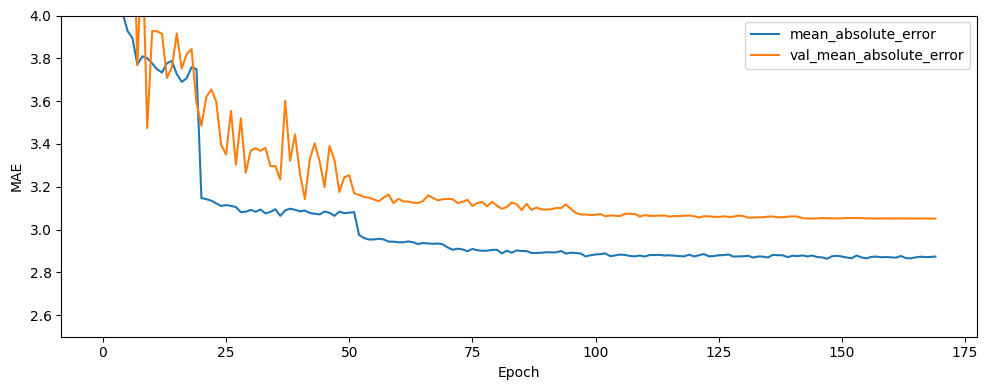

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='mean_absolute_error')
ax.plot(history.history['val_loss'], label='val_mean_absolute_error')
ax.set_ylim(2.5, 4)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(train_dataset))}')
print(f'Valid MAE: {mean_absolute_error(y_valid, model.predict(valid_dataset))}')

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train MAE: 2.7860604612383324
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Valid MAE: 3.051577800789924


## Model 2

In [ ]:
BATCH_SIZE = 128
PREFETCH = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(PREFETCH)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE).prefetch(PREFETCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(PREFETCH)


# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.28612642578089215, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(
        160, activation='leaky_relu',
        bias_regularizer=None,
        kernel_regularizer=None,
        kernel_initializer='lecun_normal'
    ),
    tf.keras.layers.Dropout(0.31774609114788727),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.0520145347426688,
    beta_1=0.9, beta_2=0.95
)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_dataset, epochs=1000, validation_data=valid_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback]
)

Epoch 1/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.9454 - mean_squared_error: 83.5861 - val_loss: 7.5193 - val_mean_squared_error: 82.2485 - learning_rate: 0.0520
Epoch 2/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5936 - mean_squared_error: 54.5981 - val_loss: 7.7819 - val_mean_squared_error: 86.2186 - learning_rate: 0.0520
Epoch 3/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9606 - mean_squared_error: 44.1789 - val_loss: 5.6095 - val_mean_squared_error: 44.6739 - learning_rate: 0.0520
Epoch 4/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5198 - mean_squared_error: 34.9796 - val_loss: 4.6847 - val_mean_squared_error: 32.3100 - learning_rate: 0.0520
Epoch 5/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0165 - mean_squared_error: 27.4032 - val_loss: 5.3119 - val_mean_squared_error: 40.8426 - learning_rate: 0.0520
Epoch 6/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8128 - mean_squared_error: 24.2146 - val_loss: 4.1384 - 

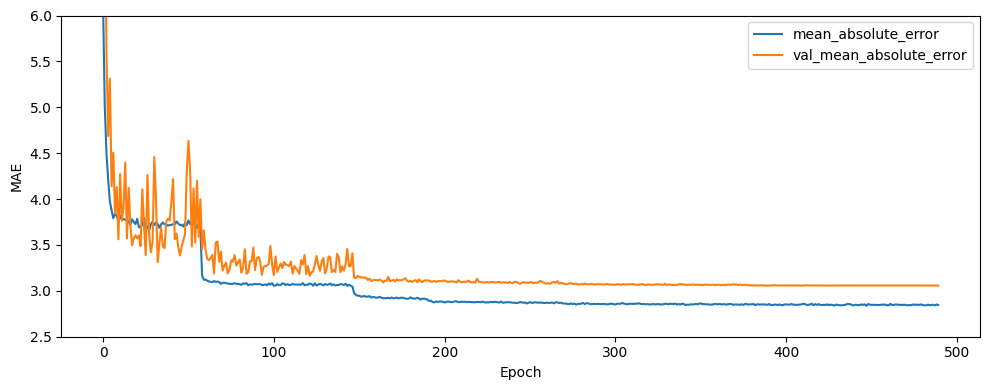

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='mean_absolute_error')
ax.plot(history.history['val_loss'], label='val_mean_absolute_error')
ax.set_ylim(2.5, 6)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(train_dataset))}')
print(f'Valid MAE: {mean_absolute_error(y_valid, model.predict(valid_dataset))}')

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train MAE: 2.7543260778953065
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Valid MAE: 3.055569537241165


## Model 3

In [14]:
BATCH_SIZE = 128
PREFETCH = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(PREFETCH)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE).prefetch(PREFETCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(PREFETCH)


# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(
        128, activation='leaky_relu',
        bias_regularizer=None,
        kernel_regularizer=None,
        kernel_initializer='lecun_normal'
    ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.005,
    beta_1=0.9, beta_2=0.95
)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_dataset, epochs=1000, validation_data=valid_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback]
)

Epoch 1/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 10.1087 - mean_squared_error: 168.6202 - val_loss: 6.6024 - val_mean_squared_error: 68.6563 - learning_rate: 0.0050
Epoch 2/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4887 - mean_squared_error: 33.8804 - val_loss: 5.6112 - val_mean_squared_error: 47.7884 - learning_rate: 0.0050
Epoch 3/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5687 - mean_squared_error: 21.1832 - val_loss: 4.2639 - val_mean_squared_error: 30.8638 - learning_rate: 0.0050
Epoch 4/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3012 - mean_squared_error: 18.4574 - val_loss: 3.7332 - val_mean_squared_error: 22.7570 - learning_rate: 0.0050
Epoch 5/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2673 - mean_squared_error: 18.1025 - val_loss: 3.5779 - val_mean_squared_error: 21.6767 - learning_rate: 0.0050
Epoch 6/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1902 - mean_squared_error: 17.3710 - val_loss: 3.4728 

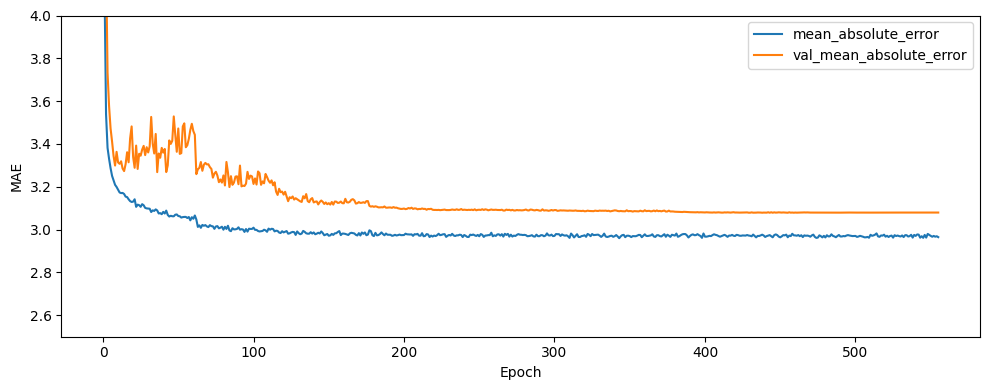

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='mean_absolute_error')
ax.plot(history.history['val_loss'], label='val_mean_absolute_error')
ax.set_ylim(2.5, 4)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(train_dataset))}')
print(f'Valid MAE: {mean_absolute_error(y_valid, model.predict(valid_dataset))}')

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train MAE: 2.828026569275177
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Valid MAE: 3.0789717562884498


## Model 4

In [19]:
BATCH_SIZE = 128
PREFETCH = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(PREFETCH)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(BATCH_SIZE).prefetch(PREFETCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(PREFETCH)


# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(
        128, activation='leaky_relu',
        bias_regularizer=None,
        kernel_regularizer=None,
        kernel_initializer='lecun_normal'
    ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.001,
    beta_1=0.9, beta_2=0.95
)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_dataset, epochs=1000, validation_data=valid_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback]
)

Epoch 1/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 17.9177 - mean_squared_error: 388.4890 - val_loss: 9.1148 - val_mean_squared_error: 123.1584 - learning_rate: 0.0010
Epoch 2/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0461 - mean_squared_error: 75.7932 - val_loss: 8.5445 - val_mean_squared_error: 120.1801 - learning_rate: 0.0010
Epoch 3/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8684 - mean_squared_error: 57.2446 - val_loss: 6.8017 - val_mean_squared_error: 74.5645 - learning_rate: 0.0010
Epoch 4/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6496 - mean_squared_error: 35.6197 - val_loss: 5.1135 - val_mean_squared_error: 44.1620 - learning_rate: 0.0010
Epoch 5/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0205 - mean_squared_error: 26.5317 - val_loss: 4.2155 - val_mean_squared_error: 29.8477 - learning_rate: 0.0010
Epoch 6/1000
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6257 - mean_squared_error: 21.7567 - val_loss: 3.673

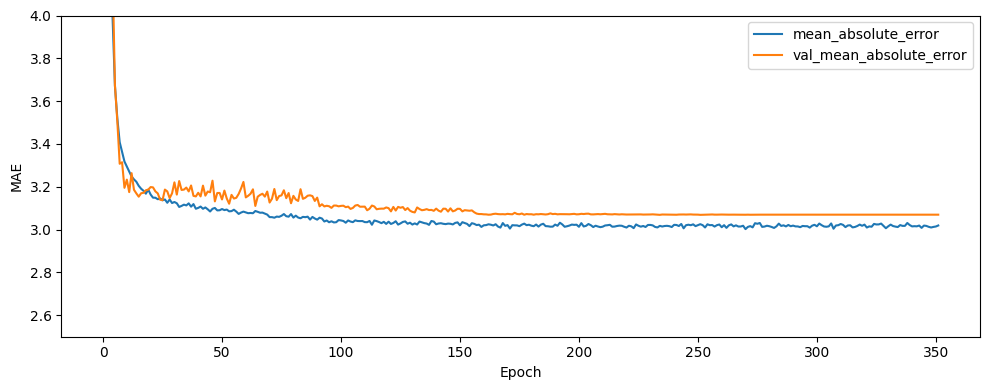

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='mean_absolute_error')
ax.plot(history.history['val_loss'], label='val_mean_absolute_error')
ax.set_ylim(2.5, 4)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(train_dataset))}')
print(f'Valid MAE: {mean_absolute_error(y_valid, model.predict(valid_dataset))}')

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train MAE: 2.813983211273579
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Valid MAE: 3.0690985849622177
